# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

/opt/anaconda3/envs/concord/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [3]:
proj_name = "simulation_trajectory"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Jun05-2116'

In [4]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
batch_type = 'batch_specific_features'
distribution = 'normal'
leiden_key = 'leiden_no_noise'

In [5]:
# Create an instance of the Simulation class
sim = ccd.ul.Simulation(n_cells=1000, n_genes=100, n_batches=2, n_states=3, 
                 state_type=state_type, 
                 state_distribution = distribution, 
                 state_level=10, 
                 state_min_level=0,
                 state_dispersion=2.0, 
                 program_structure='linear_bidirectional',
                 program_on_time_fraction=0.1,
                 trajectory_program_num=5,
                 trajectory_cell_block_size_ratio=0.6,
                 trajectory_loop_to=None,
                 batch_distribution = distribution,
                 batch_type=batch_type, 
                 batch_level=[10,10], 
                 batch_dispersion=[2.0, 2.0], 
                 non_neg=True, to_int=True,
                 seed=42)

# Generate the simulated data
adata, adata_state = sim.simulate_data()


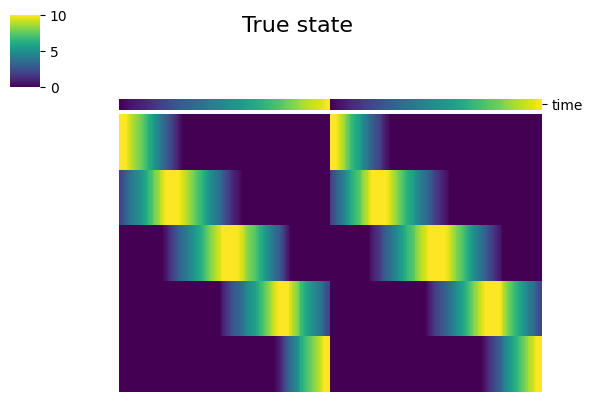

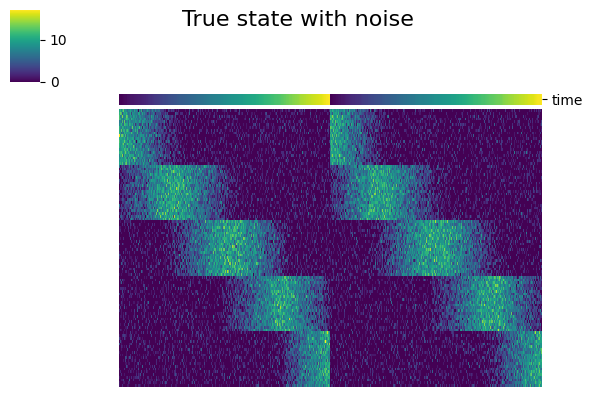

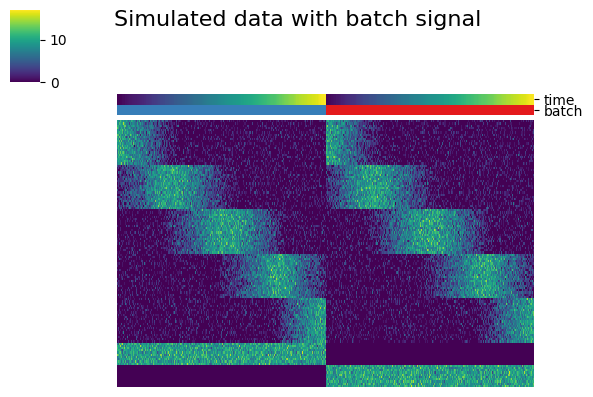

In [6]:
ccd.pl.heatmap_with_annotations(adata_state, val='no_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state', save_path=save_dir/f'true_state_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata_state, val='wt_noise', obs_keys=[state_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='True state with noise', save_path=save_dir/f'true_state_with_noise_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Simulated data with batch signal', save_path=save_dir/f'simulated_data_heatmap_{file_suffix}.png', figsize=(6, 4), dpi=300)

In [7]:
adata

AnnData object with n_obs × n_vars = 1000 × 120
    obs: 'time', 'batch'
    layers: 'no_noise', 'wt_noise', 'counts'

----

In [8]:
ccd.ul.run_scanorama(adata)

Found 120 genes among all datasets
[[0.   0.99]
 [0.   0.  ]]
Processing datasets (0, 1)


----

In [9]:
ccd.ul.run_liger(adata)

100%|██████████| 30/30 [00:01<00:00, 17.49it/s]


----

In [10]:
# run pca on the adata
ccd.ul.run_pca(adata, source_key='no_noise', result_key='X_pca')

Concord - INFO - PCA performed on source data with 50 components
Concord - INFO - PCA embedding stored in adata.obsm['X_pca']


AnnData object with n_obs × n_vars = 1000 × 120
    obs: 'time', 'batch'
    obsm: 'Scanorama', 'LIGER', 'X_pca'
    layers: 'no_noise', 'wt_noise', 'counts'

In [11]:
ccd.ul.run_harmony(adata)


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


----

In [12]:
ccd.ul.run_scvi(adata)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [00:16<00:00, 25.43it/s, v_num=1, train_loss_step=260, train_loss_epoch=196]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:16<00:00, 24.75it/s, v_num=1, train_loss_step=260, train_loss_epoch=196]


SCVI model with the following parameters: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

----

In [13]:
adata.obs["time"] = adata.obs["time"].astype(str)
adata.obs["time"] = adata.obs["time"].astype("category")


In [14]:
ccd.ul.run_scanvi(adata,
                  scvi_model=ccd.ul.run_scvi(adata, return_model=True),
                  labels_key=state_key)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [00:16<00:00, 24.96it/s, v_num=1, train_loss_step=220, train_loss_epoch=196]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:16<00:00, 24.82it/s, v_num=1, train_loss_step=220, train_loss_epoch=196]
INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|██████████| 20/20 [02:17<00:00,  6.81s/it, v_num=1, train_loss_step=475, train_loss_epoch=417]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [02:17<00:00,  6.88s/it, v_num=1, train_loss_step=475, train_loss_epoch=417]


----

In [16]:
ccd.ul.run_concord(adata)

Concord - WARNING - save_dir is None. Model and log files will not be saved.
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.


p_intra_knn: 0.3


Epoch 0 Training: 14it [00:00, 136.12it/s, loss=4.04]
Epoch 9 Training: 100%|██████████| 14/14 [00:00<00:00, 231.97it/s, loss=3.78]

Concord - WARNING - save_dir is None. Skipping model/config saving.


----

### Integration pipeline

In [17]:
combined_keys = [
        "unintegrated",
        "scanorama", "liger", "harmony",
        "scvi", "scanvi",
        "concord", "concord_class", "concord_decoder", "contrastive"
    ]
# combined_keys = ["unintegrated",
#                  "scanorama", "liger", "harmony",
#                  "scvi", "scanvi",]

In [18]:
state_key = 'time'
batch_key = 'batch'
state_type = 'trajectory'
batch_type = 'batch_specific_features'
distribution = 'normal'
leiden_key = 'leiden_no_noise'

In [19]:
time_log, ram_log, vram_log = ccd.ul.run_integration_methods_pipeline(
    adata=adata,                          # Your input AnnData object
    methods=combined_keys,            # List of methods to run
    batch_key=batch_key,                    # Column in adata.obs for batch info
    count_layer="counts",                 # Layer name containing raw counts
    class_key=state_key,               # Column in adata.obs for class labels (used in SCANVI and CONCORD variants)
    latent_dim=30,                        # Latent dimensionality for PCA and embeddings
    device="mps",                        # Or "cpu", or "mps" for Apple Silicon
    return_corrected=False,               # Whether to store corrected expression matrices
    transform_batch=None,                 # Optionally specify a batch to transform to in scVI
    seed=42,                              # Random seed for reproducibility
    compute_umap=True,                    # Run UMAP for all output embeddings
    umap_n_components=2,
    umap_n_neighbors=30,
    umap_min_dist=0.5,
    verbose=True,                        # Print progress messages
)


Concord - WARNING - save_dir is None. Model and log files will not be saved.
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.


p_intra_knn: 0.3


Epoch 0 Training: 14it [00:01,  7.63it/s, loss=4.01]
Epoch 9 Training: 100%|██████████| 14/14 [00:00<00:00, 40.35it/s, loss=3.72]

Concord - WARNING - save_dir is None. Skipping model/config saving.



concord completed in 5.99 sec.
Running UMAP on concord...


Concord - WARNING - save_dir is None. Model and log files will not be saved.
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.


p_intra_knn: 0.3


Epoch 0 Training: 14it [00:00, 16.57it/s, loss=11.2]
Epoch 9 Training: 100%|██████████| 14/14 [00:00<00:00, 30.16it/s, loss=8.86]

Concord - WARNING - save_dir is None. Skipping model/config saving.



concord_class completed in 5.29 sec.
Running UMAP on concord_class...


Concord - WARNING - save_dir is None. Model and log files will not be saved.
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.


FAISS not found. Using sklearn for k-NN computation.


p_intra_knn: 0.3


Epoch 0 Training: 14it [00:00, 19.72it/s, loss=10.3]
Epoch 9 Training: 100%|██████████| 14/14 [00:00<00:00, 37.09it/s, loss=6.51]

Concord - WARNING - save_dir is None. Skipping model/config saving.



concord_decoder completed in 4.28 sec.
Running UMAP on concord_decoder...


Concord - WARNING - save_dir is None. Model and log files will not be saved.
Concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
Concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.


FAISS not found. Using sklearn for k-NN computation.
You specified p_intra_domain as 0.95 but you only have one domain. Resetting p_intra_domain to 1.0.


p_intra_knn: 0.3


Epoch 0 Training: 15it [00:00, 39.44it/s, loss=3.84]
Epoch 9 Training: 100%|██████████| 15/15 [00:00<00:00, 44.03it/s, loss=3.55]

Concord - WARNING - save_dir is None. Skipping model/config saving.



contrastive completed in 3.61 sec.
Running UMAP on contrastive...
Running UMAP on unintegrated...
scanorama completed in 0.11 sec.
Running UMAP on scanorama...


Found 120 genes among all datasets
[[0.   0.94]
 [0.   0.  ]]
Processing datasets (0, 1)


100%|██████████| 30/30 [00:01<00:00, 17.20it/s]
liger completed in 1.83 sec.
Running UMAP on liger...
harmony completed in 0.18 sec.
Running UMAP on harmony...


	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [00:16<00:00, 24.44it/s, v_num=1, train_loss_step=208, train_loss_epoch=196]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:16<00:00, 23.72it/s, v_num=1, train_loss_step=208, train_loss_epoch=196]

scvi completed in 16.89 sec.
Running UMAP on scvi...



INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|██████████| 20/20 [02:19<00:00,  7.00s/it, v_num=1, train_loss_step=440, train_loss_epoch=413]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [02:19<00:00,  6.97s/it, v_num=1, train_loss_step=440, train_loss_epoch=413]

scanvi completed in 139.49 sec.
Running UMAP on scanvi...


✅ Selected methods completed.


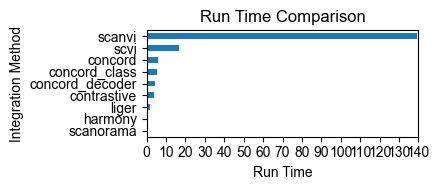

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
# Turn into a DataFrame for easier manipulation
show_keys = [method for method, time_taken in time_log.items() if time_taken is not None]
df = pd.DataFrame.from_dict(time_log, orient='index', columns=['Run Time'])

df = df.loc[show_keys]
# Sort by run time from low to high
df.sort_values(by='Run Time', inplace=True)

with plt.rc_context(rc=custom_rc):
    fig, ax = plt.subplots(figsize=(4.5, 2))

    # Plot horizontal bar chart
    df.plot(kind='barh', legend=False, ax=ax)

    # Label axes
    ax.set_xlabel("Run Time")
    ax.set_ylabel("Integration Method")
    ax.set_title("Run Time Comparison")

    # ------ Key part: set ticks at 1-hour intervals ------
    max_hours = df['Run Time'].max()
    # Create a range from 0 up to the next integer hour
    x_ticks = np.arange(0, int(max_hours) + 2, 10)  # +2 to ensure we cover the top bound
    ax.set_xticks(x_ticks)
    ax.set_xlim([0, int(max_hours)+1])  # Optional: set x-axis limit if desired

    plt.tight_layout()

    # Save and show
    # Replace save_dir / f"integration_methods_run_time_{file_suffix}.pdf" with your actual path
    plt.savefig(save_dir / f"integration_methods_run_time_{file_suffix}.pdf")
    plt.show()

In [ ]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd

# check which methods are run successfully
adata.obs['time'] = adata.obs['time'].astype(float)
show_keys = ['unintegrated'] + [method for method, time_taken in time_log.items() if time_taken is not None]
color_bys = ['time', 'batch']
basis_types = ['KNN', 'UMAP']
#basis_types = ['PCA']
font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(show_keys),1)
ncols = len(show_keys)
nrows = int(np.ceil(len(show_keys) / ncols))
pal = {'time':'viridis', 'batch':'Set1'}
k=15
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        show_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix+f'rasterized_{rasterized}',
        save_format='svg'
    )


### No batch effect, no noise

In [ ]:
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='PCA_no_noise', n_pc=30, random_state=seed)
ccd.ul.run_umap(adata_state, source_key='PCA_no_noise', result_key='UMAP_no_noise', random_state=seed)

In [ ]:
sc.pp.neighbors(adata_state, use_rep='PCA_no_noise', n_neighbors=30, random_state=seed)
sc.tl.leiden(adata_state, resolution=1.0, key_added=leiden_key, random_state=seed)
adata.obs[leiden_key] = adata_state.obs[leiden_key]

In [ ]:
show_basis = 'PCA_no_noise'
show_cols = [state_key, leiden_key, batch_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(7.5,2.5), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data', rasterized=False,
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.pdf"
)

In [ ]:
show_basis = 'UMAP_no_noise'
show_cols = [state_key, leiden_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

### NO batch effect, noise added, PCA and UMAP

In [ ]:
adata_state.X = adata_state.layers['wt_noise'].copy()
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='PCA_wt_noise', n_pc=30, random_state=seed)
ccd.ul.run_umap(adata_state, source_key='PCA_wt_noise', result_key='UMAP_wt_noise', random_state=seed)

In [ ]:
show_basis = 'PCA_wt_noise'
show_cols = [state_key, leiden_key, batch_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(7.5,2.5), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data', rasterized=False,
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.pdf"
)

In [ ]:
show_basis = 'UMAP_wt_noise'
show_cols = [state_key, leiden_key]

ccd.pl.plot_embedding(
    adata_state, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"nobatch_{show_basis}_{file_suffix}.png"
)

### No batch correction, PCA and UMAP

In [ ]:
n_pcs = min(adata.n_obs, adata.n_vars)-1
sc.pp.pca(adata, n_comps=n_pcs)
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs)
sc.tl.umap(adata, min_dist=0.5)
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

In [ ]:
show_basis = 'X_pca'
show_cols = [state_key, batch_key, leiden_key]

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"wtbatch_{show_basis}_{file_suffix}.png"
)

In [ ]:
show_basis = 'X_umap'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=20, legend_loc='on data',
    save_path=save_dir / f"wtbatch_{show_basis}_{file_suffix}.png"
)

### Concord

In [ ]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      domain_key=batch_key, # key indicating batch
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'

cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)

# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
ccd.pl.heatmap_with_annotations(adata, val='Concord', obs_keys=[state_key, batch_key], 
                                cluster_cols=True, cluster_rows=True, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'Concord_latent_heatmap_{file_suffix}.png')

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, use_rep = 'Concord')
ccd.ul.run_umap(adata, source_key='Concord', result_key='Concord_UMAP_2D', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)

show_cols = [state_key, batch_key, leiden_key]
show_basis = 'Concord_UMAP_2D'   
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    #pal = {'cluster':'Set1', 'batch':'Set2', 'leiden':'tab20'},
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)


# Run other methods

In [ ]:
file_suffix = f"{time.strftime('%b%d-%H%M')}"
ccd.set_verbose_mode(True)
show_cols = [state_key, batch_key]
timer = ccd.ul.Timer()
time_log = {}

### Scanorama

In [ ]:
output_key = 'Scanorama'

with timer:
    ccd.ul.run_scanorama(adata, batch_key="batch", output_key=output_key, return_corrected=True)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
# Plot heatmap of Scanorama corrected data
ccd.pl.heatmap_with_annotations(adata, val=f'{output_key}_corrected', obs_keys=[state_key, batch_key], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'{output_key}_corrected_heatmap_{file_suffix}.png')

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### Liger

In [ ]:
output_key = 'Liger'
adata.layers["counts"] = adata.X.copy()
with timer:
    ccd.ul.run_liger(adata, batch_key="batch", count_layer="counts", output_key=output_key, k=30, return_corrected=True)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
# Plot heatmap of Scanorama corrected data
ccd.pl.heatmap_with_annotations(adata, val=f'{output_key}_corrected', obs_keys=[state_key, batch_key], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'{output_key}_corrected_heatmap_{file_suffix}.png')

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### Harmony

In [ ]:
output_key = 'Harmony'
with timer:
    ccd.ul.run_harmony(adata, batch_key="batch", input_key='X_pca', output_key=output_key)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### scVI

In [ ]:
output_key = 'scVI'
transform_batch = 'batch_1'
with timer:
    scvi_vae = ccd.ul.run_scvi(adata, batch_key="batch", output_key=output_key, return_model=True, return_corrected=True, transform_batch=transform_batch)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
ccd.pl.heatmap_with_annotations(adata, val=f'{output_key}_corrected_{transform_batch}', obs_keys=[state_key, batch_key], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'{output_key}_{transform_batch}_corrected_heatmap_{file_suffix}.png')

In [ ]:
output_key = 'scVI'
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### scANVI

In [ ]:
output_key = 'scANVI'
with timer:
    ccd.ul.run_scanvi(adata, batch_key="batch", labels_key=leiden_key, output_key=output_key, scvi_model=scvi_vae, return_corrected=True, transform_batch=transform_batch)

time_log[output_key] = timer.interval
ccd.ul.save_obsm_to_hdf5(adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
# Plot heatmap of Scanorama corrected data
ccd.pl.heatmap_with_annotations(adata, val=f'{output_key}_corrected_{transform_batch}', obs_keys=[state_key, batch_key], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'{output_key}_{transform_batch}_corrected_heatmap_{file_suffix}.png')

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### Concord

In [ ]:
min_p_intra_domain=0.95

In [ ]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=10,
                      domain_key=batch_key, # key indicating batch
                      min_p_intra_domain=min_p_intra_domain, # probability of sampling intra-domain pairs
                      seed=seed, # random seed
                      verbose=True, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord'
with timer:
    cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
    
time_log[output_key] = timer.interval

# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### Concord with decoder

In [ ]:
decoder_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=10,
                      domain_key=batch_key, # key indicating batch
                      class_key=leiden_key, # key indicating class
                      use_classifier=False, # use classifier
                      use_decoder=True,
                      min_p_intra_domain=min_p_intra_domain, # probability of sampling intra-domain pairs
                      domain_embedding_dim=8,
                      seed=seed, # random seed
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

output_key = 'Concord-decoder'
with timer:
    decoder_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
    
time_log[output_key] = timer.interval
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(decoder_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")


In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

In [ ]:
# Predict and store the results
decoder_domains = adata.obs[batch_key].unique()
for domain in decoder_domains:
    _, decoded, _, _, _, _ = decoder_ccd.predict(decoder_ccd.loader, return_decoded=True, decoder_domain=domain, return_class=True, return_class_prob=True)
    save_key = f"{output_key}_decoded_{domain}"
    adata.layers[save_key] = decoded

adata.layers

In [ ]:
# Plot heatmap of Scanorama corrected data
ccd.pl.heatmap_with_annotations(adata, val=f'{output_key}_decoded_{transform_batch}', obs_keys=[state_key, batch_key], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis', 
                                pal = {'cluster': 'Set1', 'batch':'Set2'}, add_color_legend=True,
                                save_path=save_dir/f'{output_key}_{transform_batch}_decoded_heatmap_{file_suffix}.png')

### Concord with classifier

In [ ]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=10,
                      domain_key=batch_key, # key indicating batch
                      class_key=leiden_key, # key indicating class
                      use_classifier=True, # use classifier
                      seed=seed, # random seed
                      min_p_intra_domain=min_p_intra_domain, # probability of sampling intra-domain pairs
                      verbose=False, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord-class'
with timer:
    cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)
    
time_log[output_key] = timer.interval
# Save the latent embedding to a file, so that it can be loaded later
ccd.ul.save_obsm_to_hdf5(cur_ccd.adata, save_dir / f"obsm_{file_suffix}.h5")

In [ ]:
ccd.ul.run_umap(adata, source_key=output_key, result_key=f'{output_key}_UMAP', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)
show_basis = f'{output_key}_UMAP'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, figsize=(8,3), dpi=300, ncols=3, font_size=5, point_size=10, legend_loc='on data',
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)

### Concord without specifying domain

In [ ]:
cur_ccd = ccd.Concord(adata=adata, 
                      input_feature=None, 
                      batch_size=64,
                      n_epochs=10,
                      domain_key=None, # key indicating batch
                      seed=seed, # random seed
                      verbose=True, # print training progress
                      device=device, # device to run on
                      save_dir=save_dir # directory to save model checkpoints
                      ) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
output_key = 'Concord_nd'
cur_ccd.encode_adata(input_layer_key='X', output_key=output_key, preprocess=False)


In [ ]:
adata.obsm['Unintegrated'] = adata.obsm['X_pca']
n_pc=30
ccd.ul.run_pca(adata_state, source_key='no_noise', result_key='PCA_no_noise', n_pc=n_pc, random_state=seed)
ccd.ul.run_pca(adata_state, source_key='wt_noise', result_key='PCA_wt_noise', n_pc=n_pc, random_state=seed)

# Put the PCA result in the adata object, so only one object is needed
adata.obsm['PCA_no_noise'] = adata_state.obsm['PCA_no_noise']
adata.obsm['PCA_wt_noise'] = adata_state.obsm['PCA_wt_noise']
adata.obsm

In [ ]:
latent_keys = ["Unintegrated", "Scanorama", "Liger", "Harmony", "scVI","Concord_nd", "Concord", 'Concord-decoder', "Concord-class",  "scANVI"]
ground_keys = ['PCA_no_noise', 'PCA_wt_noise']
combined_keys = ground_keys + latent_keys 


In [ ]:


# Run umap and PCA for all latent embeddings
for basis in combined_keys:
    print("Running UMAP and PCA for", basis)
    if basis not in adata.obsm:
        continue
    #if 'UMAP' not in basis:
    ccd.ul.run_umap(adata, source_key=basis, result_key=f'{basis}_UMAP', n_components=2, n_neighbors=30, min_dist=0.8, metric='euclidean', random_state=seed)
    if 'PCA' not in basis:
        n_pc = min(adata.obsm[basis].shape[1], adata.shape[0]) - 1
        ccd.ul.run_pca(adata, source_key=basis, result_key=f'{basis}_PCA', n_pc=n_pc, random_state=seed)


In [ ]:
adata.write_h5ad(data_dir / f"adata_{file_suffix}.h5ad")
adata_state.write_h5ad(data_dir / f"adata_state_{file_suffix}.h5ad")
file_suffix

In [ ]:
# plot everything
import matplotlib.pyplot as plt
import pandas as pd


# from matplotlib import font_manager, rcParams

# # Add custom font path
# font_dirs = ['/wynton/home/gartner/zhuqin/.conda/envs/cellpath/fonts']  # Your custom fonts directory
# font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

# # Create FontProperties for each custom font and add to the font manager
# for font_path in font_files:
#     font_manager.fontManager.addfont(font_path)

# Set Arial as the default font
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

color_bys = ['time', 'batch']
basis_types = ['KNN', 'UMAP']
#basis_types = ['PCA']
font_size=8
point_size=2.5
alpha=0.8
figsize=(0.9*len(combined_keys),1)
ncols = len(combined_keys)
nrows = int(np.ceil(len(combined_keys) / ncols))
pal = {'time':'viridis', 'batch':'Set1'}
k=15
edges_color='grey'
edges_width=0
layout='kk'
threshold = 0.1
node_size_scale=0.1
edge_width_scale=0.1

rasterized = True
with plt.rc_context(rc=custom_rc):
    ccd.pl.plot_all_embeddings(
        adata,
        combined_keys,
        color_bys=color_bys,
        basis_types=basis_types,
        pal=pal,
        k=k,
        edges_color=edges_color,
        edges_width=edges_width,
        layout=layout,
        threshold=threshold,
        node_size_scale=node_size_scale,
        edge_width_scale=edge_width_scale,
        font_size=font_size,
        point_size=point_size,
        alpha=alpha,
        rasterized=rasterized,
        figsize=figsize,
        ncols=ncols,
        seed=seed,
        leiden_key='leiden',
        save_dir=save_dir,
        file_suffix=file_suffix+f'rasterized_{rasterized}',
        save_format='svg'
    )


In [ ]:
adata.layers['no_noise'] = np.zeros_like(adata.X)
adata.layers['wt_noise'] = np.zeros_like(adata.X)
# Find the indices of common genes between `adata` and `adata_state`
common_genes = adata.var_names.intersection(adata_state.var_names)
adata_indices = adata.var_names.get_indexer(common_genes)
adata_state_indices = adata_state.var_names.get_indexer(common_genes)

# Copy data from `adata_state` to `adata` for these common genes
adata.layers['no_noise'][:, adata_indices] = adata_state.layers['no_noise'][:, adata_state_indices].copy()
adata.layers['wt_noise'][:, adata_indices] = adata_state.layers['wt_noise'][:, adata_state_indices].copy()

# sort and smooth the signal along the path
batch_id=adata.obs['batch'].unique()[0]
batch_indices = np.where(adata.obs['batch'] == batch_id)[0]
_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord', path=batch_indices, sigma=2)
adata.obsm['Concord_sorted'] = adata.obsm['Concord'][:, feature_order]

_, _, _, feature_order = ccd.ul.sort_and_smooth_signal_along_path(adata, signal_key='Concord-decoder', path=batch_indices, sigma=2)
adata.obsm['Concord-decoder_sorted'] = adata.obsm['Concord-decoder'][:, feature_order]

In [ ]:
# Plot heatmap of original data and Concord latent
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 5
title_fontsize = 9
dpi = 600
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
ccd.pl.heatmap_with_annotations(adata, val='no_noise', obs_keys=[state_key], ax = axes[0], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='wt_noise', obs_keys=[state_key], ax = axes[1], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key], ax = axes[2], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='State+noise+batch', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord_sorted', obs_keys=[state_key, batch_key], ax = axes[3], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
ccd.pl.heatmap_with_annotations(adata, val='Concord-decoder_sorted', obs_keys=[state_key, batch_key], ax = axes[4], use_clustermap=False, yticklabels=False, cluster_cols=False, cluster_rows=False, value_annot=False, cmap='viridis', title='Concord-decoder latent', save_path=None, figsize=figsize, dpi=dpi, title_fontsize=title_fontsize)
plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"all_heatmaps_{file_suffix}.svg", dpi=dpi, bbox_inches='tight')

# Evaluation

In [ ]:
adata = sc.read(data_dir / f"adata_Nov24-2032.h5ad")
adata_state = sc.read(data_dir / f"adata_state_Nov24-2032.h5ad")

In [ ]:
from scipy.sparse.csgraph import minimum_spanning_tree
knn_graph = adata_b1.obsp['connectivities']
# Compute the minimum spanning tree
mst_sparse = minimum_spanning_tree(knn_graph)

# Convert the MST to a sparse COO matrix (easier to work with)
mst_coo = mst_sparse.tocoo()

# Extract edges from the MST
mst_coo = mst_sparse.tocoo()  # Convert MST to COO format for easier processing

# Get the coordinates of nodes (cells) in the embedding
embedding = adata_b1.obsm[show_basis]  # Use UMAP embedding (or PCA, etc.)

# Extract the coordinates of the edges
edges_x = []
edges_y = []

for i, j in zip(mst_coo.row, mst_coo.col):
    edges_x.append([embedding[i, 0], embedding[j, 0]])  # x-coordinates of the edge
    edges_y.append([embedding[i, 1], embedding[j, 1]])  # y-coordinates of the edge

import matplotlib.pyplot as plt

# Scatter plot of the embedding
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], s=10, c=adata_b1.obs["time"], cmap="viridis")

# Plot the edges of the MST
for x, y in zip(edges_x, edges_y):
    plt.plot(x, y, color="black", linewidth=0.1)  # Draw edges

# Add labels and legend
plt.title("Minimum Spanning Tree on UMAP Embedding")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Pseudotime")
plt.legend()
plt.show()

from scipy.sparse.csgraph import dijkstra
root_node=0
# Compute shortest path lengths from the root node
distances, predecessors = dijkstra(mst_sparse, directed=False, return_predecessors=True, indices=root_node)
# Assign pseudotime directly to nodes
pseudotime = distances

# Project pseudotime onto all cells
cell_pseudotime = np.zeros(adata_b1.n_obs)

# Iterate over all cells
for i, cell in enumerate(adata_b1.obsm[show_basis]):
    min_dist = float("inf")
    assigned_time = 0
    for start, end, weight in zip(mst_coo.row, mst_coo.col, mst_coo.data):
        # Get coordinates of the two nodes defining the edge
        coord_start, coord_end = adata_b1.obsm[show_basis][start], adata_b1.obsm[show_basis][end]
        
        # Project cell onto the edge
        edge_vector = coord_end - coord_start
        cell_vector = cell - coord_start
        proj_length = np.dot(cell_vector, edge_vector) / np.dot(edge_vector, edge_vector)
        proj_length = np.clip(proj_length, 0, 1)  # Clip to edge bounds
        proj_point = coord_start + proj_length * edge_vector
        dist = np.linalg.norm(cell - proj_point)
        
        # Assign pseudotime based on projection
        if dist < min_dist:
            min_dist = dist
            assigned_time = (1 - proj_length) * pseudotime[start] + proj_length * pseudotime[end]
    
    cell_pseudotime[i] = assigned_time

# Normalize pseudotime to 0-1
cell_pseudotime = (cell_pseudotime - cell_pseudotime.min()) / (cell_pseudotime.max() - cell_pseudotime.min())

# Add to AnnData
adata_b1.obs["pseudotime_mst"] = cell_pseudotime


### Scib

In [ ]:
from scib_metrics.benchmark import Benchmarker
bm = Benchmarker(
    adata,
    batch_key=batch_key,
    label_key=leiden_key,
    embedding_obsm_keys=latent_keys,
    n_jobs=6,
)
bm.benchmark()

In [ ]:
import matplotlib.pyplot as plt
import os
bm.plot_results_table(min_max_scale=False, show=False)
fig = plt.gcf()
fig.set_size_inches(15, 6) 
fig.savefig(os.path.join(save_dir, f'scibmetrics_results_{file_suffix}.pdf'), facecolor='white', dpi=600)
plt.show()
plt.close(fig)

In [ ]:
scib_scores = bm.get_results(min_max_scale=False)
# Convert row 'Metric Type' to multi-index column, first level is 'Metric Type', second level is existing column name
metric_type = scib_scores.loc['Metric Type']
scib_scores = scib_scores.drop('Metric Type')  # Drop the last row now that it's stored in metric_type
scib_scores.columns = pd.MultiIndex.from_tuples([(metric_type[col], col) for col in scib_scores.columns])
scib_scores = ccd.ul.benchmark_stats_to_score(scib_scores, min_max_scale=False, one_minus=False, aggregate_score=False, rank=True, rank_col=('Aggregate score', 'Total'), name_exact=False)

ccd.pl.plot_benchmark_table(scib_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', save_path=save_dir / f"scib_results_{file_suffix}.pdf", figsize=(16, 6), dpi=300)

### Topology

Run topological analysis pipeline:

In [ ]:
homology_dimensions = [0,1,2]
concord_keys = ['Concord', 'Concord-decoder', 'Concord-class']
#diagrams = {}
#for key in combined_keys:
for key in concord_keys:
    print(f"Computing persistent homology for {key}")
    diagrams[key] =  ccd.ul.compute_persistent_homology(adata, key=key, homology_dimensions=homology_dimensions)

import pickle
with open(save_dir / f"topology_diagrams_{file_suffix}.pkl", 'wb') as f:
    pickle.dump(diagrams, f)

In [ ]:
save_dir / f"topology_diagrams_{file_suffix}.pkl"

In [ ]:
import pickle
with open(Path('../save/dev_simulation_trajectory-Nov24') / f"topology_diagrams_Nov24-2032.pkl", 'rb') as f:
    diagrams = pickle.load(f)

In [ ]:
topology_results = ccd.ul.benchmark_topology(diagrams, expected_betti_numbers=[0,0,0], save_dir=save_dir, file_suffix=file_suffix)
max_betti = 5
topology_metrics = topology_results['combined_metrics'].drop(index=['PCA_no_noise', 'PCA_wt_noise'])
topology_metrics[('Betti number', 'L1 distance')] = topology_metrics[('Betti number', 'L1 distance')].clip(upper=5)
agg_name1 = 'Topology'
agg_name2 = 'Score'
topology_scores = ccd.ul.benchmark_stats_to_score(topology_metrics, min_max_scale=True, one_minus=True, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
ccd.pl.plot_benchmark_table(topology_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"topology_results_{file_suffix}.pdf", figsize=(6, 6), dpi=300)

In [ ]:
# Reorder diagrams with the same order as the combined keys
diagrams_ordered = {key: diagrams[key] for key in combined_keys}
# Change the key names to remove 'PCA_'
diagrams_ordered = {key.replace('PCA_', ''): diagrams_ordered[key] for key in diagrams_ordered}
ccd.pl.plot_persistence_diagrams(diagrams_ordered, base_size=(1.3, 1.5), dpi=300, marker_size=4, n_cols=11, fontsize=10, save_path=save_dir / f"persistence_diagrams_{file_suffix}.pdf", legend=False, label_axes=False, axis_ticks=False)

In [ ]:
ccd.pl.plot_betti_curves(diagrams_ordered, nbins=100, base_size=(1.3, 1.5), n_cols=11, fontsize=10, save_path=save_dir / f"betti_curves_{file_suffix}.pdf", dpi=300, legend=False, label_axes=False, axis_ticks=False)

In [ ]:
# compare connectivity for latent vs ground truth, store the result in a pandas dataframe
groundtruth_keys = {'(nn)': 'PCA_no_noise','(wn)': 'PCA_wt_noise'}
connectivity_df = ccd.ul.benchmark_graph_connectivity(adata, emb_keys=combined_keys, groundtruth_keys=groundtruth_keys, k=30)
agg_name1 = 'Connectivity'
agg_name2 = 'Score'
connectivity_scores = ccd.ul.benchmark_stats_to_score(connectivity_df, min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2), name_exact=False)
ccd.pl.plot_benchmark_table(connectivity_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"connectivity_results_{file_suffix}.pdf", figsize=(8, 8), dpi=300)


# Geomtric Features 

### Integrated benchmark pipeline

In [ ]:
latent_keys = ["Unintegrated", "Scanorama", "Liger", "Harmony", "scVI", "scANVI", "Concord", 'Concord-decoder', "Concord-class"]
ground_keys = ['PCA_no_noise', 'PCA_wt_noise']
combined_keys = ground_keys + latent_keys 

In [ ]:
geometry_metrics = ['pseudotime', 'cell_distance_corr', 'local_distal_corr', 'trustworthiness', 'state_distance_corr', 'state_dispersion_corr', 'state_batch_distance_ratio']
dist_metric = 'cosine'
corr_types = ['pearsonr', 'spearmanr', 'kendalltau']
#groundtruth_key = 'PCA_wt_noise'
groundtruth_key = 'PCA_no_noise'
# Convert state_dispersion to a dict of groundtruth dispersion
#groundtruth_dispersion = {'cluster_' + str(i): state_dispersion[i]**2 for i in range(5)} # convert to variance
geometry_df, geometry_full = ccd.ul.benchmark_geometry(adata, keys=combined_keys, eval_metrics=geometry_metrics, 
                                      dist_metric=dist_metric,
                                      corr_types = corr_types,
                                      groundtruth_key = groundtruth_key,
                                      state_key = leiden_key,
                                      batch_key = batch_key,
                                      #groundtruth_dispersion = groundtruth_dispersion,
                                      dispersion_metric='var',
                                      return_type='full',
                                      start_point=0,
                                      end_point=adata.n_obs-1,
                                      pseudotime_k = 30,
                                      truetime_key = 'time',
                                      save_dir=save_dir, 
                                      file_suffix=file_suffix)

In [ ]:
agg_name1 = 'Geometry'
agg_name2 = 'Score'
geometry_scores = ccd.ul.benchmark_stats_to_score(
    geometry_df.drop(index=['PCA_no_noise', 'PCA_wt_noise']), fillna = 0,               
    min_max_scale=False, one_minus=False, aggregate_score=True, aggregate_score_name1=agg_name1, aggregate_score_name2=agg_name2, rank=True, rank_col=(agg_name1,agg_name2))
ccd.pl.plot_benchmark_table(geometry_scores, pal='PRGn', pal_agg='RdYlBu_r', cmap_method = 'minmax', agg_name = agg_name1, save_path=save_dir / f"geometry_results_noscale_{dist_metric}_{groundtruth_key}_{file_suffix}.pdf", figsize=(19, 7), dpi=300)

In [ ]:
pseudotime_result = geometry_full['Pseudotime']
pseudotime_result_no_noise = ccd.ul.compute_correlation(pseudotime_result['pseudotime'], corr_types=corr_types, groundtruth_key='PCA_no_noise')
pseudotime_result_wt_noise = ccd.ul.compute_correlation(pseudotime_result['pseudotime'], corr_types=corr_types, groundtruth_key='PCA_wt_noise')
pseudotime_result_no_noise

In [ ]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['Pseudotime']['pseudotime'], 
    correlation= geometry_full['Pseudotime']['correlation'],
    s=3,
    ground_key = 'time', fontsize=9,
    n_cols = 11, figsize=(1.7,2.1), dpi=300, save_path=save_dir / f"pseudotime_scatter_{groundtruth_key}_{file_suffix}.pdf")

In [ ]:
import matplotlib.pyplot as plt

n_cols = 11
n_rows = int(np.ceil(len(combined_keys) / n_cols))
base_size = (1.5, 1.7)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*base_size[0], n_rows*base_size[1]), dpi=300)

axes = np.atleast_2d(axes).flatten()
for basis in combined_keys:
    show_basis = basis + '_UMAP'
    if show_basis not in adata.obsm or basis not in geometry_full['Pseudotime']['pseudotime']:
        show_indices = None
        adata.obs['pseudotime_plot'] = np.nan
    else:
        show_indices = geometry_full['Pseudotime']['path'][basis]
        adata.obs['pseudotime_plot'] = geometry_full['Pseudotime']['pseudotime'][basis]
    
    show_cols = ['pseudotime_plot']

    ccd.pl.plot_embedding(
        adata, show_basis, show_cols, highlight_indices=show_indices, highlight_size=5, draw_path=True, alpha=1.0,
        font_size=12, point_size=10, path_width=1,
        legend_loc='on data', title=basis, colorbar_loc=None, rasterized=True, xlabel=None, ylabel=None, 
        ax=axes[combined_keys.index(basis)]
    )

plt.tight_layout()
plt.savefig(save_dir / f"pseudotime_embedding_{file_suffix}.pdf")

In [ ]:
ccd.pl.plot_distance_heatmap(geometry_full['cell_distance_corr']['distance'], n_cols = 11, figsize=(1.1,1.3), cbar=False, dpi=300, save_path=save_dir / f"cell_distance_hmap_{file_suffix}.pdf")

In [ ]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['cell_distance_corr']['distance'], 
    correlation= geometry_full['cell_distance_corr']['correlation'],
    s=0.1, alpha = 0.2,
    n_cols = 3, figsize=(2,2), dpi=300, save_path=save_dir / f"cell_distance_scatter_{file_suffix}.png")

In [ ]:
trustworthiness_scores = geometry_full['trustworthiness']['scores']
ccd.pl.plot_trustworthiness(trustworthiness_scores, text_shift=2, legend=True, save_path=save_dir / f"trustworthiness_{groundtruth_key}_{file_suffix}.pdf", figsize=(4,3))

In [ ]:
ccd.pl.plot_distance_heatmap(geometry_full['state_distance_corr']['distance'], 
    n_cols = 3, annot_value=False,
    figsize=(2,1.6), dpi=300, save_path=save_dir / f"cell_distance_hmap_{file_suffix}.png")

In [ ]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['state_distance_corr']['distance'], 
    correlation= geometry_full['state_distance_corr']['correlation'],
    n_cols = 3, figsize=(2,2), dpi=300, save_path=save_dir / f"state_distance_scatter_{file_suffix}.pdf")

In [ ]:
ccd.pl.plot_geometry_scatter(
    data_dict = geometry_full['state_dispersion_corr']['dispersion'], 
    correlation= geometry_full['state_dispersion_corr']['correlation'],
    s=10,
    ground_key = 'PCA_wt_noise',
    n_cols = 3, figsize=(2,2), dpi=300, save_path=save_dir / f"state_distance_scatter_{file_suffix}.pdf")

In [ ]:
plot_df = geometry_full['state_batch_distance_ratio'].drop(index=['PCA_no_noise', 'PCA_wt_noise'])
ccd.pl.plot_bar(plot_df, 'State-Batch Distance Ratio (log10)', save_path=save_dir / f"state_batch_distance_ratio_{file_suffix}.pdf", figsize=(3,2), dpi=300)

### 2.0 Decoder reconstruction

In [ ]:
adata.layers

In [ ]:
# Align and copy the layer data based on observation names
adata.layers['no_noise'] = np.zeros_like(adata.X)

# Find the indices of common genes between `adata` and `adata_state`
common_genes = adata.var_names.intersection(adata_state.var_names)
adata_indices = adata.var_names.get_indexer(common_genes)
adata_state_indices = adata_state.var_names.get_indexer(common_genes)

# Copy data from `adata_state` to `adata` for these common genes
adata.layers['no_noise'][:, adata_indices] = adata_state.layers['no_noise'][:, adata_state_indices].copy()

decoded_layers = ['Concord-decoder_decoded_batch_1', 'Concord-decoder_decoded_batch_2']
show_layers = ['no_noise', 'wt_noise'] + decoded_layers
ccd.pl.plot_adata_layer_heatmaps(adata, ncells=None, ngenes=None, layers=show_layers, cmap='viridis', vmin=0, vmax=7, 
                                 obs_keys=[state_key, batch_key], transpose=False, figsize=(6,6),  dpi=300, save_path=save_dir/f'decoded_heatmap_{file_suffix}.png')

In [ ]:
# Compute the reconstruction error between the original and reconstructed data
mse_no_noise = np.zeros(len(decoded_layers))
mse_wt_noise = np.zeros(len(decoded_layers))
state_genes = adata.var_names[adata.var_names.isin(adata_state.var_names)]
for layer in decoded_layers:
    mse_no_noise[decoded_layers.index(layer)] = ccd.ul.compute_reconstruction_error(adata[:,state_genes], 'no_noise', layer, metric='mse')
    mse_wt_noise[decoded_layers.index(layer)] = ccd.ul.compute_reconstruction_error(adata[:,state_genes], 'wt_noise', layer, metric='mse')

# Report value, mean
print(f"MSE between no_noise and decoded layers: {mse_no_noise}")
print(f"MSE between wt_noise and decoded layers: {mse_wt_noise}")
print(f"Mean MSE between no_noise and decoded layers: {np.mean(mse_no_noise):.4f}")
print(f"Mean MSE between wt_noise and decoded layers: {np.mean(mse_wt_noise):.4f}")


#### Curvature analysis

In [ ]:
basis = 'Concord'
pseudotime_k = 30
start_point = 0
end_point = 100
neighborhood = ccd.ml.Neighborhood(adata.obsm[basis], k=pseudotime_k, use_faiss=True)
path, _ = ccd.ul.shortest_path_on_knn_graph(neighborhood, k=pseudotime_k, point_a=start_point, point_b=end_point, use_faiss=True)


In [ ]:
show_cols = ['time']
show_indices = path
show_basis = basis + '_PCA'
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, highlight_indices=show_indices, highlight_size=5, draw_path=True, alpha=1.0,
    font_size=12, point_size=10, path_width=1,
    legend_loc='on data', title=basis, colorbar_loc=None, rasterized=True, xlabel=None, ylabel=None,
    figsize=(6, 6), dpi=300, save_path=save_dir / f"pseudotime_embedding_{file_suffix}.pdf"
)

In [ ]:
adata.obsm['PCA_no_noise_PCA'] = adata_state.obsm['PCA_no_noise']
adata.obsm['PCA_wt_noise_PCA'] = adata_state.obsm['PCA_wt_noise']

In [ ]:
curvature_res = {}
for basis in combined_keys:
    print(f"Computing curvature for {basis}")
    try:
        curvature_res[basis]=ccd.ul.curvatures_across_time(adata, basis=basis, k=10, time_key='time', time_interval_frac=0.05)
    except:
        print(f"Error computing curvature for {basis}")
        continue


In [ ]:
# Plot curvature as a function of time for each latent embedding in curvature_res, color by basis
import matplotlib.pyplot as plt


for basis in curvature_res:
    vals = curvature_res[basis]['curvature']
    curvature_res[basis]['curvature_minmax'] = (vals - vals.min()) / (vals.max() - vals.min())

# Plot curvature as a function of time for each latent embedding in curvature_res, color by basis
nrows = len(curvature_res)
ncols = 1
base_size=(6, 3)
ground_basis = 'PCA_no_noise'

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*base_size[0], nrows*base_size[1]), dpi=300)
for i, basis in enumerate(curvature_res):
    vals = curvature_res[basis]['curvature_minmax']
    vals_ground = curvature_res[ground_basis]['curvature_minmax']
    ax[i].plot(curvature_res[basis]['mid_time'], vals, label=basis)
    ax[i].plot(curvature_res[ground_basis]['mid_time'], vals_ground, label=ground_basis)
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Curvature')
    ax[i].legend()


plt.savefig(save_dir / f"curvature_time_{file_suffix}.pdf")



In [ ]:
# Compute correlation between curvature and groundtruth curvature
curvature_list = {
    basis: curvature_res[basis]['curvature'] for basis in curvature_res
}
corr_curvature = ccd.ul.compute_correlation(curvature_list, corr_types=corr_types, groundtruth_key=ground_basis)
corr_curvature
    

In [ ]:
len(curvature_res[basis])

In [ ]:
for basis in curvature_res:
    # Initialize the column with NaN
    adata.obs[f'curvature_{basis}'] = np.NaN

    # Assign curvature values to cells between start and end points
    for i in range(len(curvature_res[basis])):
        # Extract scalar positional indices
        start_point = int(curvature_res[basis]['start_point'].iloc[i])
        end_point = int(curvature_res[basis]['end_point'].iloc[i])

        # Assign curvature values using `.iloc` for position-based slicing
        adata.obs.iloc[start_point:end_point + 1, adata.obs.columns.get_loc(f'curvature_{basis}')] = curvature_res[basis]['curvature'].iloc[i]


In [ ]:
# Plot the curvature values on the UMAP embedding
basis = 'PCA_no_noise'
show_basis = f'{basis}_PCA'
show_cols = [f'curvature_{basis}']
ccd.pl.plot_embedding(
    adata, show_basis, show_cols, highlight_indices=None, highlight_size=5, draw_path=False, alpha=1.0,
    font_size=12, point_size=10, path_width=1,
    legend_loc='on data', title='Curvature', colorbar_loc=None, rasterized=True, xlabel=None, ylabel=None,
    figsize=(6, 6), dpi=300, save_path=save_dir / f"curvature_embedding_{file_suffix}.pdf"
)


In [ ]:

adata.obs[f'curvature_{basis}']

In [ ]:
adata.obs[f'curvature_{basis}'].max()

In [ ]:
#basis = 'PCA_no_noise'
basis = 'Concord'
k=15
neighborhood = ccd.ul.Neighborhood(adata.obsm[basis], k=k)
show_cols = ['time', f'curvature_{basis}']
adata.obs[f'curvature_{basis}'] = np.nan
#adata.obs[f'curvature_{basis}'] = np.linspace(0, 2, adata.n_obs)
show_basis = basis + '_PCA'

interval_frac = 0.06
interval = int(interval_frac * adata.n_obs)
step_frac = 0.02
step = int(step_frac * adata.n_obs)
time_vec = adata.obs['time']
time_points = np.arange(time_vec.min(), time_vec.max(), step)

for t in time_points:
    # Extract scalar positional indices
    start_time = i * step
    end_time = start_time + interval
    
    start_point = np.argmin(np.abs(time_vec - t))
    end_point = np.argmin(np.abs(time_vec - (t + interval)))

    # Assign curvature values using `.iloc` for position-based slicing
    path, _ = ccd.ul.shortest_path_on_knn_graph(neighborhood, point_a=start_point, point_b=end_point)
    curvature = ccd.ul.curvature_along_path(adata, basis=basis, path=path)
    curvature_new = pd.Series(curvature, index=path)
    curvature_old = pd.Series(adata.obs.iloc[path, adata.obs.columns.get_loc(f'curvature_{basis}')], index=path)
    #print("curvature_new", curvature_new)
    #print("curvature_old", curvature_old)
    curvature_df = pd.concat([curvature_old, curvature_new], axis=1)
    # print("curvature_df", curvature_df)
    # print("curvature_df.mean(axis=1)", curvature_df.mean(axis=1))
    adata.obs.iloc[path, adata.obs.columns.get_loc(f'curvature_{basis}')] = curvature_df.mean(axis=1)
    

ccd.pl.plot_embedding(
    adata, show_basis, show_cols, highlight_indices=None, highlight_size=30, draw_path=False, alpha=1.0, ncols=2,
    font_size=12, point_size=5, path_width=0.2,
    legend_loc='on data', title=basis, colorbar_loc=None, rasterized=True, xlabel=None, ylabel=None,
    figsize=(6, 3), dpi=300, save_path=None
)

In [ ]:
ccd.pl.heatmap_with_annotations(adata, val='X', obs_keys=[state_key, batch_key, f'curvature_PCA_no_noise', f'curvature_{basis}'], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis')

ccd.pl.heatmap_with_annotations(adata, val=basis+'_sorted', obs_keys=[state_key, batch_key, f'curvature_PCA_no_noise', f'curvature_{basis}'], 
                                cluster_cols=False, cluster_rows=False, cmap='viridis')